In [3]:
import os

# Set the environment variable
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [5]:
import torch
from sbi.inference import SNLE
import matplotlib.pyplot as plt

# Beta

## generate theta and x

In [21]:
N = int(100e3)
# theta
alphas = torch.distributions.Uniform(0.1, 3.0).sample((N,))
betas = torch.distributions.Uniform(0.1, 3.0).sample((N,))
theta = torch.stack((alphas, betas), dim=1)
print(f'theta shape: {theta.shape}')

# x
x = torch.zeros(N, 1)
for i in range(N):
    alpha, beta = theta[i]
    beta_dist = torch.distributions.Beta(alpha, beta)
    x[i] = beta_dist.sample((1,))

print(f'x shape: {x.shape}')

theta shape: torch.Size([100000, 2])
x shape: torch.Size([100000, 1])


## SNLE

In [22]:
inference = SNLE()
likelihood_estimator = inference.append_simulations(theta, x).train()


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 33 epochs.

## test likelihood

In [23]:
N_test = int(1e3)
x_test = torch.linspace(0,4, N_test).reshape(-1, 1)
theta_test = torch.stack((7*torch.ones(N_test), 1*torch.ones(N_test)), dim=1)
print(f'theta_test shape: {theta_test.shape}')

loglike = likelihood_estimator.log_prob(x_test.T, theta_test)
print(f'loglike shape: {loglike.shape}')

theta_test shape: torch.Size([1000, 2])
loglike shape: torch.Size([1, 1000])


## sampled

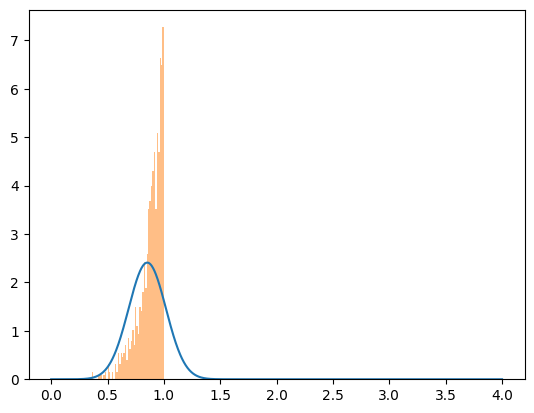

In [24]:
# generate data from theta_test
x_test_gen = torch.zeros(N_test, 1)
for i in range(N_test):
    alpha, beta = theta_test[i]
    beta_dist = torch.distributions.Beta(alpha, beta)
    x_test_gen[i] = beta_dist.sample((1,))
    
plt.plot(x_test.squeeze().detach().numpy(), loglike.exp().squeeze().detach().numpy())
plt.hist(x_test_gen.squeeze().detach().numpy(), bins=50, density=True, alpha=0.5);